In [25]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller, acf, pacf, q_stat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import probplot

df = pd.read_csv("results.csv")
df

,Date,^IRX,^SPX,up_prob,down_prob,skewness,kurtosis,mean,variance,median,p10,p90
0,2011-01-07,0.135,1271.500000,0.3169,0.2072,1.0858,-0.3065,1270.7929,41522.7438,1318,1018,1529
1,2011-01-10,0.135,1269.750000,0.3346,0.2386,1.6923,1.4680,1374.2099,122425.1209,1292,999,1550
2,2011-01-11,0.145,1274.479980,0.3283,0.2448,1.6224,1.2034,1273.0806,53592.7590,1312,969,1539
3,2011-01-12,0.145,1285.959961,0.2935,0.2107,1.7602,1.7079,1409.5604,123446.8960,1301,1054,1515
4,2011-01-13,0.140,1283.760010,0.3139,0.2282,1.6123,1.1800,1402.6875,126110.2812,1300,1032,1541
...,...,...,...,...,...,...,...,...,...,...,...,...
2527,2021-01-25,0.070,3855.360107,0.2784,0.1905,1.6098,1.2175,3853.3838,370479.6495,4001,3106,4451
2528,2021-01-26,0.068,3849.620117,0.2814,0.1883,1.4036,0.5250,3847.3655,311757.0274,3983,3158,4511
2529,2021-01-27,0.060,3750.770020,0.3490,0.1511,1.5482,1.0250,3883.0176,249330.5602,3965,3178,4393
2530,2021-01-28,0.055,3787.379883,0.3123,0.1866,1.5422,0.9786,3785.5800,416746.6931,3958,3062,4445


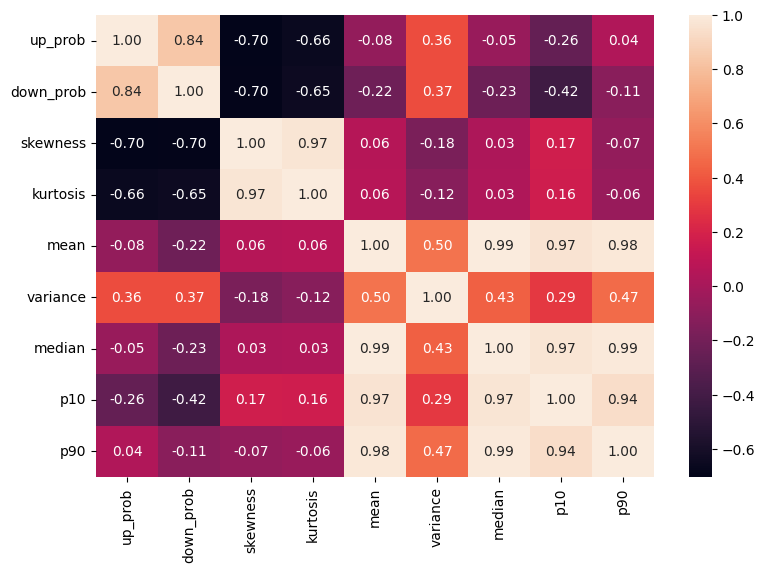

In [26]:
correlation_matrix = df[['up_prob', 'down_prob', 'skewness', 'kurtosis', 'mean', 'variance', 'median', 'p10', 'p90']].corr()


f, ax = plt.subplots(figsize=(9, 6))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", ax=ax)

plt.show()

In [27]:
# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop features
df_reduced = df.drop(columns=to_drop)

In [28]:
df1 = df_reduced.copy()
df2 = df_reduced.copy()

## First predict if the stock price show mean reversion

ADF Statistic: 0.4534266338391886
p-value: 0.9833866397299793
Critical Values:
	1%: -3.4329642237790847
	5%: -2.862694950990622
	10%: -2.5673848250020415

Time series is not stationary. Differencing the series...
ADF Statistic (diff): -10.827429799533112
p-value (diff): 1.7424431066830423e-19

ARMA(1,1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   ^SPX   No. Observations:                 2531
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -11766.503
Date:                Thu, 29 Feb 2024   AIC                          23541.006
Time:                        00:38:18   BIC                          23564.351
Sample:                             0   HQIC                         23549.476
                               - 2531                                         
Covariance Type:                  opg                                         
                 coef    std err          z     

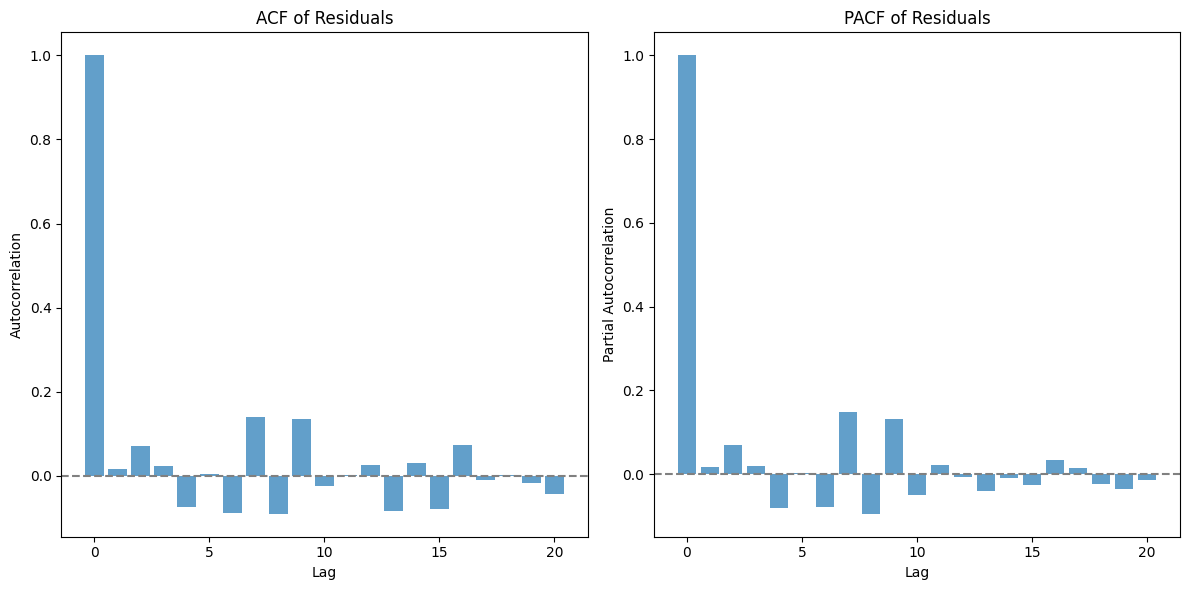

In [29]:
df1.set_index('Date', inplace=True)

# We will focus on the '^SPX' column for the ARMA model
time_series = df1['^SPX']

# Check for stationarity using the Augmented Dickey-Fuller test
adf_test = adfuller(time_series)

print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
print(f"Critical Values:")
for key, value in adf_test[4].items():
    print(f'\t{key}: {value}')

# If the time series is not stationary, we need to difference it
if adf_test[1] > 0.05:
    print("\nTime series is not stationary. Differencing the series...")
    time_series_diff = time_series.diff().dropna()
    adf_test_diff = adfuller(time_series_diff)
    print(f"ADF Statistic (diff): {adf_test_diff[0]}")
    print(f"p-value (diff): {adf_test_diff[1]}")
    time_series = time_series_diff

# Fit the ARMA model
# The order of the ARMA model (p,q) is something we would typically determine through model selection processes

# ARIMA model with order (1,0,1)
arma_model = ARIMA(time_series, order=(1,0,1))
arma_result = arma_model.fit()

print(f"\nARMA(1,1) Model Summary:\n{arma_result.summary()}")

# Check residuals for mean reversion (autocorrelations should be zero)
residuals = arma_result.resid
acf_values = acf(residuals, fft=False, nlags=20)
pacf_values = pacf(residuals, nlags=20)

# Plot the ACF and PACF
lags = np.arange(len(acf_values))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.bar(lags, acf_values, align='center', alpha=0.7)
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('ACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.subplot(122)
plt.bar(lags, pacf_values, align='center', alpha=0.7)
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('PACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()


## No, the SP500 doesnt show mean reversion

In [30]:
df2

,Date,^IRX,^SPX,up_prob,skewness,mean,variance
0,2011-01-07,0.135,1271.500000,0.3169,1.0858,1270.7929,41522.7438
1,2011-01-10,0.135,1269.750000,0.3346,1.6923,1374.2099,122425.1209
2,2011-01-11,0.145,1274.479980,0.3283,1.6224,1273.0806,53592.7590
3,2011-01-12,0.145,1285.959961,0.2935,1.7602,1409.5604,123446.8960
4,2011-01-13,0.140,1283.760010,0.3139,1.6123,1402.6875,126110.2812
...,...,...,...,...,...,...,...
2527,2021-01-25,0.070,3855.360107,0.2784,1.6098,3853.3838,370479.6495
2528,2021-01-26,0.068,3849.620117,0.2814,1.4036,3847.3655,311757.0274
2529,2021-01-27,0.060,3750.770020,0.3490,1.5482,3883.0176,249330.5602
2530,2021-01-28,0.055,3787.379883,0.3123,1.5422,3785.5800,416746.6931


## Test if features show mean reversion preidct ability


In [31]:
df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index('Date', inplace=True)

## Optimize parameter using time series cross validation


In [32]:
# Calculate daily returns of SPX
df2['SPX_returns'] = df2['^SPX'].pct_change().dropna()

target = 'SPX_returns'
features = ['up_prob', 'skewness', 'mean', 'variance']
X_train, X_test, y_train, y_test = train_test_split(df2[features], df2[target], test_size=0.2, shuffle=False)

In [33]:
# Define the p, d, q parameters to take any value from 0 to a maximum number
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Generate all different combinations of p, d, q triplets
pdq = list(itertools.product(p, d, q))

# Define the range for seasonal parameters
seasonal_pdq = [(x[0], x[1], x[2], 0) for x in pdq]  # Assuming non-seasonal data

# Define the number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# This will store the best AIC and corresponding order and seasonal order
best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None
best_model = None

warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        for train_index, test_index in tscv.split(X_train):
            try:
                # The actual endog and exog variables depend on how you've structured your data
                tmp_y_train, tmp_y_test = y_train.iloc[train_index], y_train.iloc[test_index]
                tmp_X_train, tmp_X_test = X_train.iloc[train_index], X_train.iloc[test_index]

                model = SARIMAX(tmp_y_train,
                                order=param,
                                seasonal_order=param_seasonal,
                                exog=tmp_X_train,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

                results = model.fit(disp=False)

                if results.aic < best_aic:
                    best_aic = results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_model = results

            except Exception as e:
                continue

print(f"Best SARIMAX{best_pdq}x{best_seasonal_pdq} - AIC:{best_aic}")

# Once the best parameters are found, fit the model to the entire training set
final_model = SARIMAX(y_train,
                      order=best_pdq,
                      seasonal_order=best_seasonal_pdq,
                      exog=X_train,
                      enforce_stationarity=False,
                      enforce_invertibility=False)

final_results = final_model.fit(disp=False)

# make predictions on the test set
predictions = final_results.get_forecast(steps=len(y_test), exog=X_test)
predicted_mean = predictions.predicted_mean

# Calculate error metrics
mae = mean_absolute_error(y_test, predicted_mean)
rmse = np.sqrt(mean_squared_error(y_test, predicted_mean))

print(f'\nMAE: {mae}')
print(f'RMSE: {rmse}')


Best SARIMAX(0, 0, 1)x(0, 0, 0, 0) - AIC:-9834.609634754168

MAE: 0.009527450146352062
RMSE: 0.016210117399473565


## Use Optimized paramter in model to do reversal test


ADF Statistic: -11.26958352661804
p-value: 1.548774182617643e-20
                               SARIMAX Results                                
Dep. Variable:            SPX_returns   No. Observations:                 1772
Model:               SARIMAX(0, 0, 1)   Log Likelihood                5852.517
Date:                Thu, 29 Feb 2024   AIC                         -11693.034
Time:                        00:39:59   BIC                         -11660.155
Sample:                             0   HQIC                        -11680.887
                               - 1772                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
up_prob       -0.0014      0.000     -3.750      0.000      -0.002      -0.001
skewness      -0.0006      0.000     -2.150      0.032      -0.001

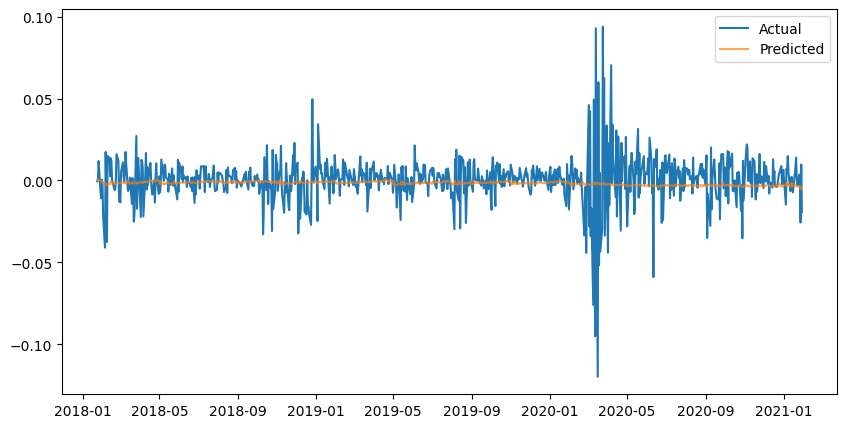

In [37]:
# Check for stationarity of returns
adf_result = adfuller(df2['SPX_returns'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

X = df2[features]
y = df2[target]

# Make sure X and y have the same number of samples
assert len(X) == len(y), "The number of samples in X and y should be the same."

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled features back into DataFrame for compatibility
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Fit the SARIMAX model
model = SARIMAX(y_train, order=(0,0,1), seasonal_order=(0,0,0,0), exog=X_train_scaled_df)
# Fit the SARIMAX model
model_fit = model.fit(disp=False)

# Summary of the model to check for mean reversion
print(model_fit.summary())

# Perform the Ljung-Box test explicitly on the residuals
residuals = model_fit.resid
acf_values = acf(residuals, fft=False)
lb_values, lb_pvalues = q_stat(acf_values[1:], len(residuals))  # exclude the zero-lag acf value
lb_value = lb_values[-1]  # take the last value
lb_pvalue = lb_pvalues[-1]  # take the last p-value

print("\nLjung-Box Test:")
print(f"Statistic: {lb_value:.3f}, p-value: {lb_pvalue:.3f}")

# Make out-of-sample predictions
predictions = model_fit.get_forecast(steps=len(y_test), exog=X_test_scaled_df)
predicted_mean = predictions.predicted_mean

# Calculate error metrics
mae = mean_absolute_error(y_test, predicted_mean)
rmse = np.sqrt(mean_squared_error(y_test, predicted_mean))

print(f'\nMAE: {mae}')
print(f'RMSE: {rmse}')

# Plot the actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, predicted_mean, label='Predicted', alpha=0.7)
plt.legend()
plt.show()